In [13]:
import cv2
import numpy as np
import sys
import os
import glob 
import random
import matplotlib.pyplot as plt

In [15]:
from PIL import Image
def get_focal_in_pixels(img_path):
    sensor_width_map = {
        'Canon DIGITAL IXUS 860 IS': 5.75,
        'DSC-W170': 6.16,
        'NEX-5N': 23.4,
        'NIKON D40': 23.7
    }
    image = Image.open(img_path)
    # try:
    focal_mm = image._getexif()[37386]
    model = image._getexif()[272]
    sensor_width_mm = sensor_width_map[model]
    image_width_pixels= image.size[0]
    del image
    print(focal_mm,image_width_pixels,sensor_width_mm)
    focal_pixels = (focal_mm * image_width_pixels) / sensor_width_mm
    return focal_pixels
def cylindricalWarp( img, f):
    """This function returns the cylindrical warp for a given image and focal length f"""
    h, w = img.shape[:2]
    # Intrinsic matrix K based on focal length f
    K = np.array([[f, 0, w / 2], 
                  [0, f, h / 2], 
                  [0, 0, 1]])  # Mock intrinsic matrix

    # Creating a meshgrid of pixel coordinates
    y_i, x_i = np.indices((h, w))
    X = np.stack([x_i, y_i, np.ones_like(x_i)], axis=-1).reshape(h * w, 3)  # Homogeneous coordinates
    Kinv = np.linalg.inv(K) 
    X = Kinv.dot(X.T).T  # Normalized coordinates

    # Calculate cylindrical coordinates
    A = np.stack([np.sin(X[:, 0]), X[:, 1], np.cos(X[:, 0])], axis=-1).reshape(w * h, 3)
    B = K.dot(A.T).T  # Project back to image plane
    B = B[:, :-1] / B[:, [-1]]  # Normalize homogeneous coordinates

    # Filter points outside image bounds and reshape
    B[(B[:, 0] < 0) | (B[:, 0] >= w) | (B[:, 1] < 0) | (B[:, 1] >= h)] = -1
    B = B.reshape(h, w, -1)

    # Warp the image using the cylindrical coordinates
    return cv2.remap(img, B[:, :, 0].astype(np.float32), B[:, :, 1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)


In [16]:
class PanoramaStitcher():
    def __init__(self):
        self.homography_matrix_list = []
        pass
    def make_panorama_for_images_in(self,path):
        imf = path
        stitched_image = np.zeros((1,1,3), np.uint8)
        all_images = sorted(glob.glob(imf+os.sep+'*'))
        print(all_images)
        aligned_images = os.makedirs(imf+os.sep+'aligned_images', exist_ok=True)    
        print("Found {} images".format(len(all_images)))
        current_images = [cv2.imread(im) for im in all_images]
        # homo = pairwise_homo(current_images)
        return stitched_image, self.homography_matrix_list

In [68]:

img = '/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I1/STA_0031.JPG'
img = '/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I2/2_1.JPG'
img = "/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I3/3_1.JPG"
img = "/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I4/DSC02930.JPG"
img = "/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I5/DSC03002.JPG"
img = "/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I6/1_1.JPG"
imf = '/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I3'
all_images = sorted(glob.glob(imf+os.sep+'*'))
for i in all_images:
    print(get_focal_in_pixels(i))


# focal_length = get_focal_in_pixels(img)
# print(focal_length)

5.0 730 6.16
592.5324675324675
5.0 730 6.16
592.5324675324675
5.0 730 6.16
592.5324675324675
5.0 730 6.16
592.5324675324675
5.0 730 6.16
592.5324675324675


In [69]:
def find_keypoint(image):
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image, None)
    return kp, des
def match_keypoints(kp1,kp2,des1, des2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 2)
    return src_pts , dst_pts
def homography(src_pts, dst_pts, max_iter=1000, inlier_thr=5):
    assert(len(src_pts) >= 4)
    assert(len(dst_pts) == len(src_pts))
    # apply RANSAC algorithm
    best_inlier = 0     # number of points that are below threshold
    best_dist = float('inf')
    homography_matrices = []
    for _ in range(max_iter):
        # pick 4 random point pairs
        idx = random.sample(range(len(src_pts)), 4)
        # calculate homography matrix
        x1, x2, x3, x4 = ((src_pts[i][0], dst_pts[i][0]) for i in idx)
        y1, y2, y3, y4 = ((src_pts[i][1], dst_pts[i][1]) for i in idx)
        P = np.array([
            [-x1[0], -y1[0], -1, 0, 0, 0, x1[0] * x1[1], y1[0] * x1[1], x1[1]],
            [0, 0, 0, -x1[0], -y1[0], -1, x1[0] * y1[1], y1[0] * y1[1], y1[1]],
            [-x2[0], -y2[0], -1, 0, 0, 0, x2[0] * x2[1], y2[0] * x2[1], x2[1]],
            [0, 0, 0, -x2[0], -y2[0], -1, x2[0] * y2[1], y2[0] * y2[1], y2[1]],
            [-x3[0], -y3[0], -1, 0, 0, 0, x3[0] * x3[1], y3[0] * x3[1], x3[1]],
            [0, 0, 0, -x3[0], -y3[0], -1, x3[0] * y3[1], y3[0] * y3[1], y3[1]],
            [-x4[0], -y4[0], -1, 0, 0, 0, x4[0] * x4[1], y4[0] * x4[1], x4[1]],
            [0, 0, 0, -x4[0], -y4[0], -1, x4[0] * y4[1], y4[0] * y4[1], y4[1]],
            ])
        [U, S, Vt] = np.linalg.svd(P)
        H = Vt[-1].reshape(3, 3)
        H /= H[2][2]
        # see how good the matches are
        pts = transform(src_pts, H)
        distvec = np.sqrt(np.sum(np.square(pts - dst_pts), axis=1))
        dist = np.mean(distvec[distvec < inlier_thr])
        inlier = np.count_nonzero(distvec < inlier_thr)
        homography_matrices.append(H)
        if inlier > best_inlier or (inlier is best_inlier and dist < best_dist):
            best_inlier = inlier
            best_dist = dist
            best_H = H
        
    return best_H, homography_matrices
def transform(src_pts, H):
        src = np.pad(src_pts, [(0, 0), (0, 1)], constant_values=1)
        pts = np.dot(H, src.T).T
        pts = (pts / pts[:,-1].reshape(-1, 1))[:, 0:2]
        return pts


In [70]:
all_images = sorted(glob.glob(imf+os.sep+'*'))
focal_lengths = [get_focal_in_pixels(i) for i in all_images]
all_images = [cv2.imread(i) for i in all_images]
all_images = [cylindricalWarp(i, f) for i, f in zip(all_images, focal_lengths)]
print(focal_lengths)
# mid = 0
# stitched_image = np.zeros((1,1,3), np.uint8)
# if len(all_images)%2 == 0: # 0 1 2 3 4 5
#     mid = len(all_images)//2 
#     left_images = all_images[:mid-1]
#     right_images = all_images[mid+1:]
#     # stitched_image = stitch_image(all_images[mid-1], all_images[mid])
# else: # 0 1 2 3 4 
#     mid = len(all_images)//2
#     left_images = all_images[:mid]
#     right_images = all_images[mid+1:]
#     stitched_image = all_images[mid-1]
    
# tot = len(left_images) - 1
# alt = 0
# while(alt < len(left_images)):
#     img_left = left_images[tot - alt]
#     stitched_image = stitch_image(img_left, stitched_image)

#     img_right = right_images[alt]
#     stitched_image = stitch_image(stitched_image, img_right)

# plt.imshow(stitched_image)
# print(len(left_images), len(right_images))

5.0 730 6.16
5.0 730 6.16
5.0 730 6.16
5.0 730 6.16
5.0 730 6.16
[592.5324675324675, 592.5324675324675, 592.5324675324675, 592.5324675324675, 592.5324675324675]


In [71]:
def warp_perspective(img, H, shape):
    """Manually warp an image using the homography matrix H."""
    h, w = shape
    y, x = np.indices((h, w))
    dst_hom_pts = np.stack((x.ravel(), y.ravel(), np.ones(y.size)))
    src_hom_pts = np.dot(np.linalg.inv(H), dst_hom_pts)
    src_hom_pts /= src_hom_pts[2]  # Normalize homogeneous coordinates

    # Map coordinates to image boundaries
    src_x = np.clip(src_hom_pts[0].round().astype(int), 0, img.shape[1] - 1)
    src_y = np.clip(src_hom_pts[1].round().astype(int), 0, img.shape[0] - 1)

    # Assign pixels from src to dst
    warped_img = np.zeros((h, w, 3), dtype=img.dtype)
    warped_img[y.ravel(), x.ravel()] = img[src_y, src_x]
    
    return warped_img
def gradient_domain_blending(img1, img2, mask1, mask2):
    """
    Perform gradient domain blending
    
    Args:
    img1, img2: Input images
    mask1, mask2: Blending masks
    
    Returns:
    Blended image
    """
    # Compute gradients
    def compute_gradient(img):
        gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        return gx, gy
    
    # Blend gradients
    def blend_gradients(g1, g2, w1, w2):
        return (w1 * g1 + w2 * g2) / (w1 + w2 + 1e-10)
    
    # Compute gradients for each channel
    blended_image = np.zeros_like(img1, dtype=np.float64)
    
    for channel in range(3):
        # Extract channel
        ch1 = img1[:,:,channel].astype(np.float64)
        ch2 = img2[:,:,channel].astype(np.float64)
        
        # Compute gradients
        gx1, gy1 = compute_gradient(ch1)
        gx2, gy2 = compute_gradient(ch2)
        
        # Blend gradients
        blended_gx = blend_gradients(gx1, gx2, mask1, mask2)
        blended_gy = blend_gradients(gy1, gy2, mask1, mask2)
        
        # Reconstruct image using Poisson reconstruction
        blended_channel = cv2.solve(
            cv2.Laplacian(blended_image[:,:,channel]), 
            blended_gx + blended_gy, 
            flags=cv2.DECOMP_LU
        )[1]
        
        blended_image[:,:,channel] = blended_channel
    
    return np.clip(blended_image, 0, 255).astype(np.uint8)

def stitch_images_gradient(img1, img2, homography):
    """
    Stitch images using gradient domain blending
    
    Args:
    img1, img2: Input images
    homography: Transformation matrix
    
    Returns:
    Stitched image
    """
    # [Previous warping and transformation code remains the same]
    h, w = img1.shape[:2]
    corners = np.array([[0, 0, 1], [w, 0, 1], [w, h, 1], [0, h, 1]]).T
    transformed_corners = homography @ corners
    transformed_corners /= transformed_corners[2]  # Normalize by the last coordinate

    # Calculate output image dimensions
    min_x = min(0, transformed_corners[0].min())
    min_y = min(0, transformed_corners[1].min())
    max_x = max(img2.shape[1], transformed_corners[0].max())
    max_y = max(img2.shape[0], transformed_corners[1].max())

    # Offset translation matrix to place the stitched image at (0,0)
    translation = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    result_shape = (int(max_y - min_y), int(max_x - min_x), 3)
    result = np.zeros(result_shape, dtype=np.uint8)

    # Warp img1 to the new image space
    warp_matrix = translation @ homography
    warped_img1 = warp_perspective(img1, warp_matrix, result_shape[:2])

    # Paste img2 into the result with offset
    result[-int(min_y):-int(min_y) + img2.shape[0], -int(min_x):-int(min_x) + img2.shape[1]] = img2
    
    # Create masks
    mask_warped = (warped_img1.sum(axis=2) > 0).astype(np.float32)
    mask_img2 = (result.sum(axis=2) > 0).astype(np.float32)
    
    # Perform gradient domain blending
    final_image = gradient_domain_blending(warped_img1, result, mask_warped, mask_img2)
    
    return final_image

In [72]:
import cv2
import numpy as np

def stitch_images(img1, img2, homography):
    """Stitch two images using warping and blending."""
    # Define the bounds of img1 in homography space
    h, w = img1.shape[:2]
    corners = np.array([[0, 0, 1], [w, 0, 1], [w, h, 1], [0, h, 1]]).T
    transformed_corners = homography @ corners
    transformed_corners /= transformed_corners[2]  # Normalize by the last coordinate

    # Calculate output image dimensions
    min_x = min(0, transformed_corners[0].min())
    min_y = min(0, transformed_corners[1].min())
    max_x = max(img2.shape[1], transformed_corners[0].max())
    max_y = max(img2.shape[0], transformed_corners[1].max())

    # Offset translation matrix to place the stitched image at (0,0)
    translation = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    result_shape = (int(max_y - min_y), int(max_x - min_x), 3)
    result = np.zeros(result_shape, dtype=np.uint8)

    # Warp img1 to the new image space
    warp_matrix = translation @ homography
    warped_img1 = warp_perspective(img1, warp_matrix, result_shape[:2])

    # Paste img2 into the result with offset
    result[-int(min_y):-int(min_y) + img2.shape[0], -int(min_x):-int(min_x) + img2.shape[1]] = img2

    # Blending
    mask_warped = (warped_img1.sum(axis=2) > 0).astype(np.uint8)
    mask_img2 = (result.sum(axis=2) > 0).astype(np.uint8)

    # Apply distance transform to create blend weights
    w1 = cv2.distanceTransform(mask_warped, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    w1 = cv2.normalize(w1, None, 0, 1.0, cv2.NORM_MINMAX)
    w2 = cv2.distanceTransform(mask_img2, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    w2 = cv2.normalize(w2, None, 0, 1.0, cv2.NORM_MINMAX)
    blend_w1 = w1 / (w1 + w2 + 1e-12)
    blend_w2 = w2 / (w1 + w2 + 1e-12)
    
    # Blend images
    final_image = (blend_w1[..., None] * warped_img1 + blend_w2[..., None] * result).astype(np.uint8)
    return final_image

def warp_perspective(img, H, shape):
    """Manually warp an image using the homography matrix H."""
    h, w = shape
    y, x = np.indices((h, w))
    dst_hom_pts = np.stack((x.ravel(), y.ravel(), np.ones(y.size)))
    src_hom_pts = np.dot(np.linalg.inv(H), dst_hom_pts)
    src_hom_pts /= src_hom_pts[2]  # Normalize homogeneous coordinates

    # Map coordinates to image boundaries
    src_x = np.clip(src_hom_pts[0].round().astype(int), 0, img.shape[1] - 1)
    src_y = np.clip(src_hom_pts[1].round().astype(int), 0, img.shape[0] - 1)

    # Assign pixels from src to dst
    warped_img = np.zeros((h, w, 3), dtype=img.dtype)
    warped_img[y.ravel(), x.ravel()] = img[src_y, src_x]
    
    return warped_img


In [74]:
homography_matrix_list = []
def stitch_image(image1,image2):
    img1 = image1.copy()
    img2 = image2.copy()
    kp1, des1 = find_keypoint(img1)
    kp2, des2 = find_keypoint(img2)
    src_pts, dst_pts = match_keypoints(kp1, kp2, des1, des2)
    H, homography_matrices = homography(src_pts, dst_pts)
    homography_matrix_list.append(homography_matrices)

    sti = stitch_images(img1,img2,H)
    return sti



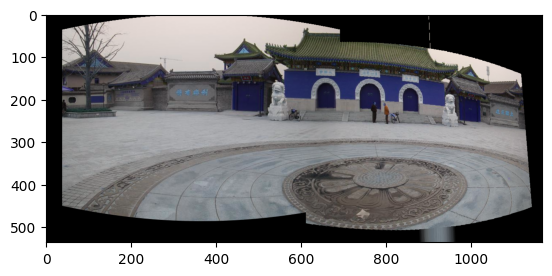

In [75]:
# 0 1 2 3 4 
img1 = all_images[2]
img2 = all_images[1]
st = stitch_image(img1,img2)
plt.imshow(st)


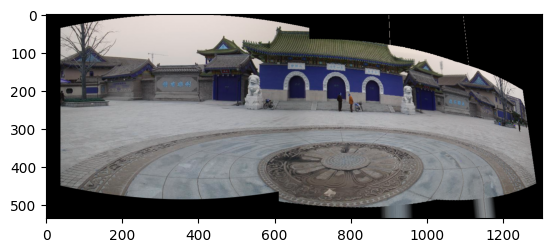

In [76]:
img1 = all_images[3]
img2 = st
st = stitch_image(img1,img2)
plt.imshow(st)

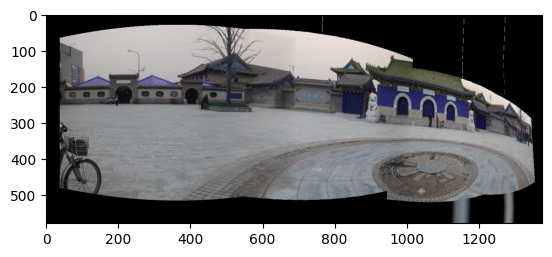

In [77]:
img1 = st
img2 = all_images[0]
st = stitch_image(img1,img2)
plt.imshow(st)

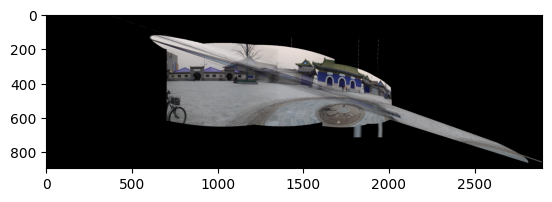

In [78]:
img2 = st
img1 = all_images[4]
st = stitch_image(img1,img2)
plt.imshow(st)

In [44]:
import pdb
import glob
import cv2
import os
import numpy as np
import sys 
import random
import matplotlib.pyplot as plt
from PIL import Image

class PanaromaStitcher():
    def __init__(self):
        pass

    def get_focal_in_pixels(self,img_path: str) -> float:
        from PIL import Image
        sensor_width_map = {
            'Canon DIGITAL IXUS 860 IS': 5.75,
            'DSC-W170': 6.16,
            'NEX-5N': 23.4,
            'NIKON D40': 23.7
        }
        image = Image.open(img_path)
        # try:
        focal_mm = image._getexif()[37386]
        model = image._getexif()[272]
        sensor_width_mm = sensor_width_map[model]
        image_width_pixels= image.size[0]
        del image
        print(focal_mm,image_width_pixels,sensor_width_mm)
        focal_pixels = (focal_mm * image_width_pixels) / sensor_width_mm
        return focal_pixels

    def cylindricalWarp( self,img, f):
        """This function returns the cylindrical warp for a given image and focal length f"""
        h, w = img.shape[:2]
        # Intrinsic matrix K based on focal length f
        K = np.array([[f, 0, w / 2], 
                    [0, f, h / 2], 
                    [0, 0, 1]])  # Mock intrinsic matrix

        # Creating a meshgrid of pixel coordinates
        y_i, x_i = np.indices((h, w))
        X = np.stack([x_i, y_i, np.ones_like(x_i)], axis=-1).reshape(h * w, 3)  # Homogeneous coordinates
        Kinv = np.linalg.inv(K) 
        X = Kinv.dot(X.T).T  # Normalized coordinates

        # Calculate cylindrical coordinates
        A = np.stack([np.sin(X[:, 0]), X[:, 1], np.cos(X[:, 0])], axis=-1).reshape(w * h, 3)
        B = K.dot(A.T).T  # Project back to image plane
        B = B[:, :-1] / B[:, [-1]]  # Normalize homogeneous coordinates

        # Filter points outside image bounds and reshape
        B[(B[:, 0] < 0) | (B[:, 0] >= w) | (B[:, 1] < 0) | (B[:, 1] >= h)] = -1
        B = B.reshape(h, w, -1)

        # Warp the image using the cylindrical coordinates
        return cv2.remap(img, B[:, :, 0].astype(np.float32), B[:, :, 1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    def find_keypoint(self,image):
        sift = cv2.SIFT_create(contrastThreshold=0.01, edgeThreshold=10)
        kp, des = sift.detectAndCompute(image, None)

        return kp, des
    def match_keypoints(self,kp1,kp2,des1, des2):
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1, des2, k=2)
        good = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good.append(m)
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 2)
        return src_pts , dst_pts
    
    def homography(self,src_pts, dst_pts, max_iter=10000, inlier_thr=10):
        print(len(src_pts),len(dst_pts))
        assert(len(src_pts) >= 4)
        assert(len(dst_pts) == len(src_pts))
        # apply RANSAC algorithm
        best_inlier = 0     # number of points that are below threshold
        best_dist = float('inf')
        homography_matrices = []
        for _ in range(max_iter):
            # pick 4 random point pairs
            idx = random.sample(range(len(src_pts)), 4)
            # calculate homography matrix
            x1, x2, x3, x4 = ((src_pts[i][0], dst_pts[i][0]) for i in idx)
            y1, y2, y3, y4 = ((src_pts[i][1], dst_pts[i][1]) for i in idx)
            P = np.array([
                [-x1[0], -y1[0], -1, 0, 0, 0, x1[0] * x1[1], y1[0] * x1[1], x1[1]],
                [0, 0, 0, -x1[0], -y1[0], -1, x1[0] * y1[1], y1[0] * y1[1], y1[1]],
                [-x2[0], -y2[0], -1, 0, 0, 0, x2[0] * x2[1], y2[0] * x2[1], x2[1]],
                [0, 0, 0, -x2[0], -y2[0], -1, x2[0] * y2[1], y2[0] * y2[1], y2[1]],
                [-x3[0], -y3[0], -1, 0, 0, 0, x3[0] * x3[1], y3[0] * x3[1], x3[1]],
                [0, 0, 0, -x3[0], -y3[0], -1, x3[0] * y3[1], y3[0] * y3[1], y3[1]],
                [-x4[0], -y4[0], -1, 0, 0, 0, x4[0] * x4[1], y4[0] * x4[1], x4[1]],
                [0, 0, 0, -x4[0], -y4[0], -1, x4[0] * y4[1], y4[0] * y4[1], y4[1]],
                ])
            [U, S, Vt] = np.linalg.svd(P)
            H = Vt[-1].reshape(3, 3)
            H /= H[2][2]
            # see how good the matches are
            pts = self.transform(src_pts, H)
            distvec = np.sqrt(np.sum(np.square(pts - dst_pts), axis=1))
            dist = np.mean(distvec[distvec < inlier_thr])
            inlier = np.count_nonzero(distvec < inlier_thr)
            homography_matrices.append(H)
            if inlier > best_inlier or (inlier is best_inlier and dist < best_dist):
                best_inlier = inlier
                best_dist = dist
                best_H = H
            
        return best_H, homography_matrices
    
    def transform(self,src_pts, H):
            src = np.pad(src_pts, [(0, 0), (0, 1)], constant_values=1)
            pts = np.dot(H, src.T).T
            pts = (pts / pts[:,-1].reshape(-1, 1))[:, 0:2]
            return pts
    
    def warp_perspective(self,img, H, shape):
        """Manually warp an image using the homography matrix H."""
        h, w = shape
        y, x = np.indices((h, w))
        dst_hom_pts = np.stack((x.ravel(), y.ravel(), np.ones(y.size)))
        src_hom_pts = np.dot(np.linalg.inv(H), dst_hom_pts)
        src_hom_pts /= src_hom_pts[2]  # Normalize homogeneous coordinates

        # Map coordinates to image boundaries
        src_x = np.clip(src_hom_pts[0].round().astype(int), 0, img.shape[1] - 1)
        src_y = np.clip(src_hom_pts[1].round().astype(int), 0, img.shape[0] - 1)

        # Assign pixels from src to dst
        warped_img = np.zeros((h, w, 3), dtype=img.dtype)
        warped_img[y.ravel(), x.ravel()] = img[src_y, src_x]
        
        return warped_img

    def stitch_images(self,img1: np.array, img2: np.array, homography: np.array) -> np.array:
        """Stitch two images using warping and blending."""
        # Define the bounds of img1 in homography space
        h, w = img1.shape[:2]
        corners = np.array([[0, 0, 1], [w, 0, 1], [w, h, 1], [0, h, 1]]).T
        transformed_corners = homography @ corners
        transformed_corners /= transformed_corners[2]  # Normalize by the last coordinate

        # Calculate output image dimensions
        min_x = min(0, transformed_corners[0].min())
        min_y = min(0, transformed_corners[1].min())
        max_x = max(img2.shape[1], transformed_corners[0].max())
        max_y = max(img2.shape[0], transformed_corners[1].max())

        # Offset translation matrix to place the stitched image at (0,0)
        translation = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
        result_shape = (int(max_y - min_y), int(max_x - min_x), 3)
        result = np.zeros(result_shape, dtype=np.uint8)

        # Warp img1 to the new image space
        warp_matrix = translation @ homography
        warped_img1 = self.warp_perspective(img1, warp_matrix, result_shape[:2])

        # Paste img2 into the result with offset
        result[-int(min_y):-int(min_y) + img2.shape[0], -int(min_x):-int(min_x) + img2.shape[1]] = img2

        # Blending
        mask_warped = (warped_img1.sum(axis=2) > 0).astype(np.uint8)
        mask_img2 = (result.sum(axis=2) > 0).astype(np.uint8)

        # Apply distance transform to create blend weights
        w1 = cv2.distanceTransform(mask_warped, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
        w1 = cv2.normalize(w1, None, 0, 1.0, cv2.NORM_MINMAX)
        w2 = cv2.distanceTransform(mask_img2, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
        w2 = cv2.normalize(w2, None, 0, 1.0, cv2.NORM_MINMAX)
        blend_w1 = w1 / (w1 + w2 + 1e-12)
        blend_w2 = w2 / (w1 + w2 + 1e-12)
        
        # Blend images
        final_image = (blend_w1[..., None] * warped_img1 + blend_w2[..., None] * result).astype(np.uint8)
        return final_image 
    
    def stitch_image(self,image1,image2):
        img1 = image1.copy()
        img2 = image2.copy()
        kp1, des1 = self.find_keypoint(img1)
        kp2, des2 = self.find_keypoint(img2)
        src_pts, dst_pts = self.match_keypoints(kp1, kp2, des1, des2)
        print(len(src_pts),len(dst_pts))
        H, homography_matrices = self.homography(src_pts, dst_pts)
        # self.homography_matrix_list.append(homography_matrices)
        # H = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]
        sti = self.stitch_images(img1,img2,H)
        print("YES I WORKED")
        return sti,H

    def make_panaroma_for_images_in(self,path):
        imf = path
        all_images = sorted(glob.glob(imf+os.sep+'*'))
        print('Found {} Images for stitching'.format(len(all_images)))
        homography_matrix_list =[]
        focal_length = [self.get_focal_in_pixels(img) for img in all_images]
        all_images = [cv2.imread(img) for img in all_images]
        print('Focal Lengths:',focal_length)
        # Warp images
        warped_images = [self.cylindricalWarp(img, f) for img, f in zip(all_images, focal_length)]
        id = [i for i in range(len(warped_images))]
        id_left = []
        id_right = []
        all_images = warped_images
        mid = 0
        stitched_image = np.zeros((1,1,3) ,dtype=np.uint8)
        if len(all_images)%2 == 0: # 0 1 2 3 4 5
            mid = len(all_images)//2 
            left_images = all_images[:mid-1]
            id_left = id[:mid-1]
            right_images = all_images[mid+1:]
            id_right = id[mid+1:]
            stitched_image,H = self.stitch_image(all_images[mid-1], all_images[mid])
        else: # 0 1 2 3 4 
            mid = len(all_images)//2
            left_images = all_images[:mid]
            id_left = id[:mid]
            right_images = all_images[mid+1:]
            id_right = id[mid+1:]
            stitched_image = all_images[mid-1]

        # return stitched_image
        print(id_left)
        print(id_right)
        left_images = left_images[::-1]
        for i in range(len(left_images)):
            # stitched_image,homo = self.stitch_image(stitched_image,left_images[i])
            stitched_image,homo = self.stitch_image(right_images[i],stitched_image)
            
            # stitch_images.append(stitched_image)
            homography_matrix_list.append(homo)
            stitched_image,homo = self.stitch_image(left_images[i],stitched_image)
            # stitched_image,homo = self.stitch_image(stitched_image,right_images[i])


        #####
        return stitched_image, homography_matrix_list 


In [45]:
st = PanaromaStitcher()
# images = '/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I1'
# a,b = st.make_panaroma_for_images_in('/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I3')
# I1= st.make_panaroma_for_images_in('/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I1')
# plt.imshow(I1[0])




Found 5 Images for stitching
4.6 653 5.75
4.6 653 5.75
4.6 653 5.75
4.6 653 5.75
4.6 653 5.75
Focal Lengths: [522.4, 522.4, 522.4, 522.4, 522.4]
[0, 1]
[3, 4]
3072 3072
3072 3072
YES I WORKED
106 106
106 106
YES I WORKED
28 28
28 28
YES I WORKED
36 36
36 36
YES I WORKED


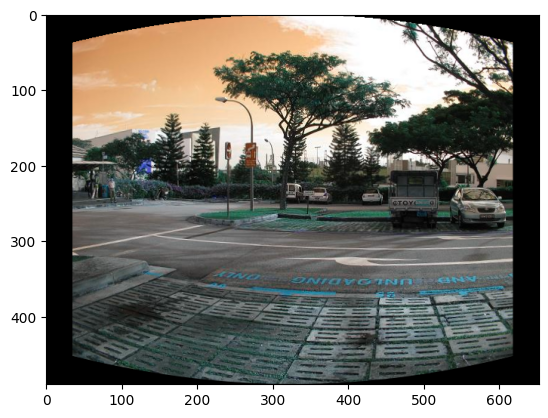

In [46]:
I2= st.make_panaroma_for_images_in('/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I2')
plt.imshow(I2[0])

Found 5 Images for stitching
5.0 730 6.16
5.0 730 6.16
5.0 730 6.16
5.0 730 6.16
5.0 730 6.16
Focal Lengths: [592.5324675324675, 592.5324675324675, 592.5324675324675, 592.5324675324675, 592.5324675324675]
[0, 1]
[3, 4]
3575 3575
3575 3575
YES I WORKED
66 66
66 66
YES I WORKED
38 38
38 38
YES I WORKED
23 23
23 23
YES I WORKED


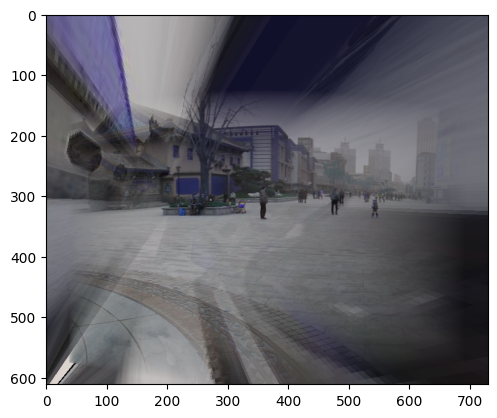

In [47]:
I3= st.make_panaroma_for_images_in('/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I3')
plt.imshow(I3[0])

Found 5 Images for stitching
18.0 4000 23.4
18.0 2000 23.4
18.0 2000 23.4
18.0 2000 23.4
18.0 2000 23.4
Focal Lengths: [3076.923076923077, 1538.4615384615386, 1538.4615384615386, 1538.4615384615386, 1538.4615384615386]
[0, 1]
[3, 4]
24874 24874
24874 24874
YES I WORKED
3565 3565
3565 3565
YES I WORKED
2422 2422
2422 2422
YES I WORKED
3324 3324
3324 3324
YES I WORKED


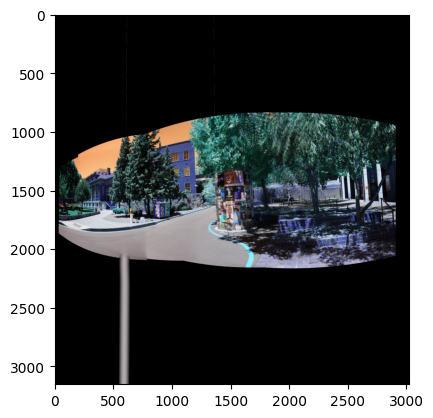

In [48]:
I4= st.make_panaroma_for_images_in('/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I4')
plt.imshow(I4[0])

Found 5 Images for stitching
18.0 2000 23.4
18.0 2000 23.4
18.0 2000 23.4
18.0 2000 23.4
18.0 2000 23.4
Focal Lengths: [1538.4615384615386, 1538.4615384615386, 1538.4615384615386, 1538.4615384615386, 1538.4615384615386]
[0, 1]
[3, 4]
18615 18615
18615 18615
YES I WORKED
4070 4070
4070 4070
YES I WORKED
2259 2259
2259 2259
YES I WORKED
4465 4465
4465 4465
YES I WORKED


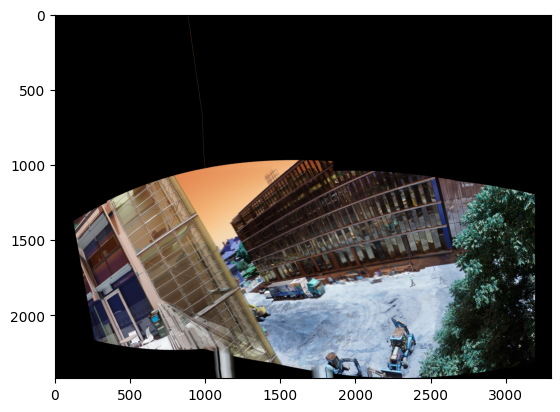

In [49]:

I5= st.make_panaroma_for_images_in('/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I5')
plt.imshow(I5[0])

Found 5 Images for stitching
24.0 602 23.7
24.0 602 23.7
24.0 602 23.7
26.0 602 23.7
26.0 602 23.7
Focal Lengths: [609.620253164557, 609.620253164557, 609.620253164557, 660.42194092827, 660.42194092827]
[0, 1]
[3, 4]
2113 2113
2113 2113
YES I WORKED
613 613
613 613
YES I WORKED
381 381
381 381
YES I WORKED
667 667
667 667
YES I WORKED


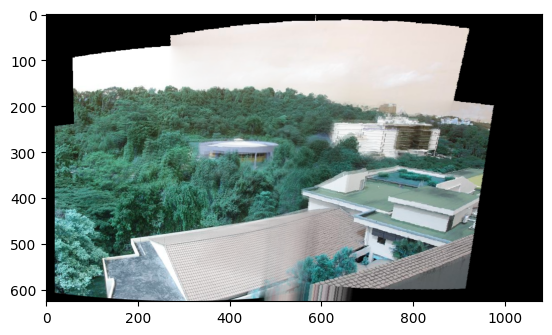

In [50]:
I6= st.make_panaroma_for_images_in('/home/pikabell/Tools/assignment3/ES666-Assignment3/Images/I6')
plt.imshow(I6[0])